# Exponential models

This notebook is to play around with exponential models.

## Install libraries to cloud worker

In [1]:
! conda install statsmodels -y
! conda install scikit-learn -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



## Import modules

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

## Read data to memory

In [11]:
df = pd.read_csv("../outputs/mutational_model_stats.tsv", sep="\t")
df.head(4)

,tri,ref,alt,lvl,mu,sqrt_mu,obs,pos
0,AAA,A,C,0,1.800000e-09,0.000042,0.046519,27021
1,AAA,A,G,0,3.010000e-09,0.000055,0.098643,204496
2,AAA,A,T,0,1.040000e-09,0.000032,0.026177,42557
3,AAC,A,C,0,1.420000e-09,0.000038,0.032891,14989


### Key variables
- "pos": Number of possible mutations
- "obs": Proportion of possible mutations which are observed
- "mu": The "mutability" of a given sequence (i.e. how likely is a mutation)

## Plot "mu" vs "obs"

In [12]:
sns.set_context("talk")

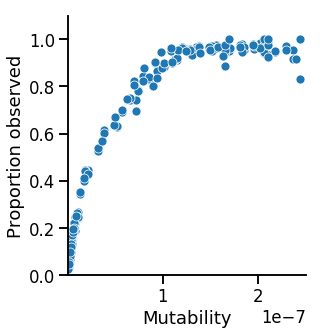

In [13]:
g = (sns.relplot(kind="scatter",
                 data=df,
                 x="mu",
                 y="obs",
                )
    )
(g.set(xlim=(8.9*10**-10, 2.5*10**-7),
       ylim=(0,1.1),
       xlabel="Mutability",
       ylabel="Proportion observed"
      )
)

This looks like a nice exponential relationship which caps at 1. (The proportion of observed variants can't be >1).

I want to fit a curve which describes this relationship. Later, I want to use this model to predict "obs" (the proportion observed) for other values of "mu" (mutability).

In [14]:
print(f"Rows = {len(df)}")
print(f'There are {(df["obs"]==1).sum()} observations for which "obs" == 1. Drop them.')
df = df[df["obs"] != 1].copy()
print(f"Rows remaining = {len(df)}")

Rows = 304
There are 5 observations for which "obs" == 1. Drop them.
Rows remaining = 299


## Where Alex is struggling...

The approach below is taken from published work which I am trying to replicate.

In [42]:
# Fit a polynomial equation
fit = np.polyfit(df["mu"], np.log(1 - df["obs"]), 1, w=(df["pos"]))

print(f"fit = {fit}")

# The formula y = np.log(1 - df["obs"]) is taken from published work which I am replicating.
# Why am I using this? 
# Why not simply y = np.log(df["obs"]) ?

# w (weights) is slightly arbitrary. I have weighted on the number of possible variants, "pos",
# which seems intuitive. (There are some rows for which very few variants are possible).

A,B = fit # Get the coefficients
print(f"A = {A}")
print(f"B = {B}")

# This equation is used to fit "obs"
# Is it consistent with the equation above?
df["fit_obs"] = 1 - (np.exp(B)) * (np.exp(A * df["mu"]))

# R**2 for "obs" and "fit_obs"
print(f'R2 for "obs" vs "fit_obs" = {r2_score(df["obs"], df["fit_obs"])}')
# Why have they given this statistic? Ultimately I am interested in "mu" vs "obs".

# Finally, is there a role for a np.poly1d object?
# I can't find a way to reconcile this with the fit equation, above.
p = np.poly1d(fit)

# For example, where the highest mutability is 2.44*10**-7
print(f"{p(2.44*10**-7)}")

fit = [-2.32233214e+07 -3.86560516e-02]
A = -23223321.413843006
B = -0.03865605157918833
R2 for "obs" vs "fit_obs" = 0.9934281046076844
-5.705146476556881


### Plots for the published approach
These look good, but I am struggling to understand the logic in the cell above.

Also, I do not know how to make predictions from the model.

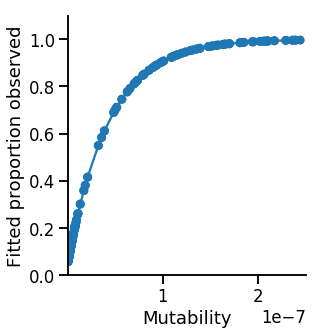

In [46]:
# Plot "mu" vs "fit_obs"
g = (sns.relplot(kind="scatter",
                 data=df,
                 x="mu",
                 y="fit_obs",
                 edgecolor="none",
               )
    )

# Modify figure
(g.set(xlim=(8.9*10**-10, 2.5*10**-7),
       ylim=(0,1.1),
       xlabel="Mutability",
       ylabel="Fitted proportion observed",
      )
)

# Add trend line
plt.plot(sorted(df["mu"]), sorted(df["fit_obs"]))

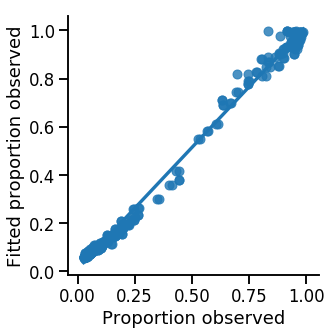

In [45]:
# Plot "obs" vs "fit_obs"
g = sns.lmplot(data=df, x="obs", y="fit_obs")
g.set(xlabel = "Proportion observed", ylabel="Fitted proportion observed")